In [201]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# Make plots inline
%matplotlib inline

In [202]:
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
df

,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112
3,87.2093,1.501669
4,87.1246,2.002225
...,...,...
1794,103.7900,897.997775
1795,101.6230,898.498331
1796,99.5679,898.998888
1797,99.1835,899.499444


In [224]:
train_size = 300 #at the head
test_size = 100 #in the middle
train_size2 = 300 #at the tail
split = train_size + test_size + train_size2

#get training set
train = df[0:train_size].append(df[train_size + test_size:split]) 
X_train = np.array(train['time'])
Y_train = np.array(train['Y'])

#get testing set
test = df[train_size:train_size+test_size]
X_test = np.array(test['time'])
Y_test = np.array(test['Y'])

# Below df are only used for poltting the data
# we add nan in between 2 parts of training data to avoid the straight line between twp training set in later plotting
df_train_two_side = df.copy(deep=True)
df_train_two_side['Y'][train_size:train_size+test_size] = np.nan
train_2_side = df_train_two_side[0:split]
X_train_with_nan = np.array(train_2_side['time'])
Y_train_with_nan = np.array(train_2_side['Y'])

/var/folders/cr/310gdfw15c9flzll2l__zdnm0000gn/T/ipykernel_54793/3911230653.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df[0:train_size].append(df[train_size + test_size:split])


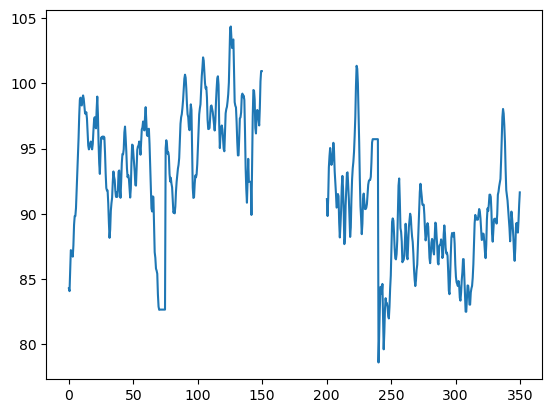

In [225]:
plt.plot(X_train_with_nan,Y_train_with_nan)

In [226]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)

X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

X_train_with_nan = torch.tensor(X_train_with_nan)
Y_train_with_nan = torch.tensor(Y_train_with_nan) 

In [227]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel, PeriodicKernel, CosineKernel, MaternKernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(PeriodicKernel()+RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x, likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [236]:

likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(train_size+train_size2) * 0.01, learn_additional_noise=True)
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, Y_train, likelihood)

In [237]:
training_iterations = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(X_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, Y_train)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        torch.cuda.empty_cache()

# See dkl_mnist.ipynb for explanation of this flag
%time train()

Iter 1/100 - Loss: 31.779
Iter 2/100 - Loss: 29.885
Iter 3/100 - Loss: 28.445
Iter 4/100 - Loss: 26.950
Iter 5/100 - Loss: 25.568
Iter 6/100 - Loss: 24.284
Iter 7/100 - Loss: 23.089
Iter 8/100 - Loss: 21.993
Iter 9/100 - Loss: 20.982
Iter 10/100 - Loss: 20.037
Iter 11/100 - Loss: 19.174
Iter 12/100 - Loss: 18.370
Iter 13/100 - Loss: 17.629
Iter 14/100 - Loss: 16.940
Iter 15/100 - Loss: 16.300
Iter 16/100 - Loss: 15.714
Iter 17/100 - Loss: 15.166
Iter 18/100 - Loss: 14.646
Iter 19/100 - Loss: 14.197
Iter 20/100 - Loss: 13.763
Iter 21/100 - Loss: 13.327


/Users/brett/opt/anaconda3/envs/gpytorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 22/100 - Loss: 12.931
Iter 23/100 - Loss: 12.605
Iter 24/100 - Loss: 12.244
Iter 25/100 - Loss: 11.970
Iter 26/100 - Loss: 11.681
Iter 27/100 - Loss: 11.405
Iter 28/100 - Loss: 11.172
Iter 29/100 - Loss: 10.931
Iter 30/100 - Loss: 10.712
Iter 31/100 - Loss: 10.501
Iter 32/100 - Loss: 10.300
Iter 33/100 - Loss: 10.120
Iter 34/100 - Loss: 9.946
Iter 35/100 - Loss: 9.779
Iter 36/100 - Loss: 9.615
Iter 37/100 - Loss: 9.467
Iter 38/100 - Loss: 9.323
Iter 39/100 - Loss: 9.187
Iter 40/100 - Loss: 9.060
Iter 41/100 - Loss: 8.934
Iter 42/100 - Loss: 8.817
Iter 43/100 - Loss: 8.707
Iter 44/100 - Loss: 8.595
Iter 45/100 - Loss: 8.498
Iter 46/100 - Loss: 8.399
Iter 47/100 - Loss: 8.307
Iter 48/100 - Loss: 8.209
Iter 49/100 - Loss: 8.122
Iter 50/100 - Loss: 8.042
Iter 51/100 - Loss: 7.961
Iter 52/100 - Loss: 7.888
Iter 53/100 - Loss: 7.807
Iter 54/100 - Loss: 7.732
Iter 55/100 - Loss: 7.668
Iter 56/100 - Loss: 7.603
Iter 57/100 - Loss: 7.531
Iter 58/100 - Loss: 7.470
Iter 59/100 - Loss: 7.411


In [238]:
model.eval()
likelihood.eval()
with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    preds = model(X_test)
    train = model(X_train)

/Users/brett/opt/anaconda3/envs/gpytorch/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [242]:
preds.stddev

tensor([0.8623, 1.0358, 1.2041, 1.3468, 1.4561, 1.5310, 1.5799, 1.6084, 1.6219,
        1.6290, 1.6309, 1.6316, 1.6326, 1.6326, 1.6327, 1.6329, 1.6331, 1.6325,
        1.6325, 1.6329, 1.6328, 1.6327, 1.6332, 1.6328, 1.6324, 1.6329, 1.6327,
        1.6327, 1.6327, 1.6332, 1.6326, 1.6323, 1.6330, 1.6327, 1.6327, 1.6330,
        1.6330, 1.6324, 1.6326, 1.6328, 1.6327, 1.6327, 1.6332, 1.6327, 1.6323,
        1.6329, 1.6327, 1.6327, 1.6328, 1.6332, 1.6325, 1.6324, 1.6330, 1.6328,
        1.6327, 1.6330, 1.6330, 1.6324, 1.6327, 1.6328, 1.6327, 1.6327, 1.6332,
        1.6327, 1.6323, 1.6330, 1.6327, 1.6327, 1.6328, 1.6332, 1.6325, 1.6324,
        1.6329, 1.6328, 1.6327, 1.6331, 1.6329, 1.6324, 1.6328, 1.6328, 1.6327,
        1.6327, 1.6332, 1.6326, 1.6323, 1.6330, 1.6326, 1.6323, 1.6322, 1.6315,
        1.6282, 1.6219, 1.6089, 1.5804, 1.5321, 1.4586, 1.3490, 1.2061, 1.0397,
        0.8656], dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [239]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - Y_test))))

Test MAE: 4.350045791384667


In [244]:
y_pred_train_with_nan = np.concatenate((np.array(train.mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train.mean[train_size:]))) 
y_pred_std_train_with_nan = np.concatenate((np.array(train.stddev[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train.stddev[train_size:]))) 
y_pred_test = np.array(preds.mean)
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(12,8))

#plot training data
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data')

# plot training prediction
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction')

#plot testing data
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data')

#plot testing prediction
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction')

#add CI
plt.fill_between(np.squeeze(X_test), (y_pred_test- y_pred_std_train_with_nan).ravel(), (y_pred_test+y_pred_std_train_with_nan).ravel(), color='blue',alpha = 0.2)

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.